In [13]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer
from pytorchcv.model_provider import get_model

class OriDualEfficientViT(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15,backbone="xception_net", version="cross_attention-spatial-cat",weight=0.5,freeze=0):  
        super(OriDualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        # "cross_attention-spatial-cat": sử dụng cross-attention, cat với spatial vectors output
        # "cross_attention-spatial-add": sử dụng cross-attention, add với spatial vectors output
        # "cross_attention-freq-cat": sử dụng cross-attention, cat với freq vectors
        # "cross_attention-freq-add": sử dụng cross-attention, add với freq vectors
        # "merge-add": cộng thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        # "merge-cat": cat thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        self.version = version
        self.weight = weight

        self.backbone = backbone
        self.spatial_extractor = self.get_feature_extractor(freeze=freeze, architecture=backbone, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(freeze=freeze, architecture=backbone, num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="xception_net", freeze=0, pretrained=True, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', pretrained=True, num_classes=num_classes,in_channels = in_channels)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            if freeze:
            # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                print("Here")
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - 3:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

        print("Pretrained backbone: ", bool(pretrained))
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        print("in scale dot.")
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        print('q after: ', q)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        print("attn: ", attn)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, ifreqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        print("q before scaledot: ", spatials)
        print("k before scaledot: ", ifreqs)
        print("v before scaledot: ", ifreqs)
        emb_dim = spatials.shape[2]
        assert emb_dim == ifreqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, ifreqs, ifreqs)
        return attn_outputs, attn_weights

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.spatial_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.spatial_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, spatial_imgs, frequency_imgs):
        p = self.patch_size
        # Extract features
        # print(frequency_imgs)
        spatial_features, freq_features = self.extract_feature(spatial_imgs, frequency_imgs)                     # shape (batchsize, 1280, 8, 8)conda
        ifreq_features = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_features))) + 1e-10)  # Hơi ảo???
        # return spatial_features, freq_features, ifreq_features
        # print(ifreq_features.shape)
        # assert(ifreq_features.shape == freq_features.shape)
        # print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = rearrange(spatial_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        freq_vectors = rearrange(freq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        ifreq_vectors = rearrange(ifreq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        print("1: ", spatial_vectors)
        print("2: ", ifreq_vectors)
        print("3: ", ifreq_vectors)
        if "cross_attention" in self.version:          # Merge using cross-attention  
            ########## Patch embedding and add position embedding to each domain:
            # spatial_vectors = self.patch_to_embedding_1(spatial_vectors)
            # spatial_vectors += self.pos_embedding_1

            # freq_vectors = self.patch_to_embedding_2(freq_vectors)
            # freq_vectors += self.pos_embedding_2

            # ifreq_vectors = self.patch_to_embedding_2(ifreq_vectors)
            # ifreq_vectors += self.pos_embedding_2  
            # print("Step 2 shape: ", spatial_vectors.shape, freq_vectors.shape)  # (batchsize, num_patches, D)
            ##########
        
            # Cal attn weight between ifreq and spatial vectors:
            # Cross-attention (spatial-decoder, ifreq-encoder)
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, ifreq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            print("Attn weights: \n", attn_outputs, attn_weights)
            if "freq" in self.version:          # Get attention in frequency domain:
                out_attn = torch.bmm(attn_weights, freq_vectors)
            elif "spatial" in self.version:     # Get attention in spatial domain:
                out_attn = torch.bmm(attn_weights, ifreq_vectors)
                ### Check correct bmm:
                # print(torch.eq(attn_outputs, out_attn))
            else:
                pass

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        print("Fusion out: \n", out)
        print("Embed: ", embed)
        # print("Embeded shape: ", embed.shape)

        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, num_patches+1, dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        print("x before scaledot: ", q)
        print("y before scaledot: ", k)
        print("z before scaledot: ", v)
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        print("in scale dot.")
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        print('q after: ', q)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        print("attn: ", attn)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class MyDualEfficientViT(nn.Module):
    def __init__(self, \
                image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft=True,\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, position_embed=False, pool='cls',\
                version='ca-fcat-0.5', unfreeze_blocks=-1, \
                init_linear="xavier", init_layernorm="normal", init_conv="kaiming"):  
        super(MyDualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.position_embed = position_embed
        self.pool = pool
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)
        self.normalize = nn.BatchNorm2d(num_features=self.out_ext_channels) if normalize_ifft else nn.Identity()
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Number of vectors:
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        # Embed vị trí cho từng vectors (nếu chia theo patch):
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_vecs+1, self.dim))
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        # self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        else:
            activation = None
        return activation

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        ifreq_feature = self.normalize(ifreq_feature)
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features)
        # return rgb_features, freq_features, ifreq_features
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        # print("1: ", rgb_query_vectors)
        # print("2: ", ifreq_key_vectors)
        # print("3: ", ifreq_value_vectors)
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)

        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        print("Fusion: \n", fusion_out)
        print("embed: ", embed)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, in_dim+1, dim)
        if self.position_embed:
            x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x.mean(dim = 1) if self.pool == 'mean' else x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    torch.manual_seed(0)
    x = torch.ones(1, 3, 128, 128)
    y = torch.ones(1, 1, 128, 128)
    model_1 = MyDualEfficientViT( image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                                backbone='xception_net', pretrained=True,\
                                normalize_ifft=False,\
                                flatten_type='patch',\
                                conv_attn=False, ratio=1, qkv_embed=False, inner_ca_dim=0, init_ca_weight=False, prj_out=False, act='none',\
                                patch_size=1, position_embed=True, pool='cls',\
                                version='ca-fadd-0.8', unfreeze_blocks=-1)
    # model_1.eval()
    # with torch.no_grad():
    #     print("Model 1")
    #     rgb_1, freq_1, ifreq_1 = model_1(x, y)
    #     print("************************************* RGB 1 ***")
    #     # print(freq_1)
    #     import numpy as np


    # model_2 = OriDualEfficientViT(channels=2048, image_size=128, num_classes=1, dim=1024,\
    #                             depth=6, heads=8, mlp_dim=2048,\
    #                             dim_head=64, dropout=0.15, emb_dropout=0.15,\
    #                             patch_size=1, backbone="xception_net", version='cross_attention-freq-add', weight=0.8, freeze=0)
    # model_2.eval()
    # with torch.no_grad():
    #     print("Model 2")
    #     rgb_2, freq_2, ifreq_2 = model_2(x, y)
    #     print("************************************* RGB 2 ***")
    #     print(freq_2)

    # if torch.equal(rgb_1, rgb_2):
    #     print("Equal rgb")
    # if torch.equal(freq_1, freq_2):
    #     print("Equal freq")
    # if torch.equal(ifreq_1, ifreq_2):
    #     print("Equal ifreq")
    extractor = []
    rest = []
    for name, param in model_1.named_parameters():
        if 'extractor' in name:
            extractor.append(param)
        else:
            rest.append(param)

    from torch.optim import Adam
    optim = Adam(
        [
            {"params": extractor, "lr": 1e-3},
            {"params": rest, "lr": 1e-4},
        ],
    )
    print("lr = ", [optim.param_groups[i]['lr'] for i in range(len(optim.param_groups))])

Pretrained backbone:  True
Pretrained backbone:  True
lr =  [0.001, 0.0001]


In [13]:
import torch
import torch.nn.functional as F
from model.vision_transformer.dual_cnn_vit.pairwise_dual_cnn_vit import PairwiseDualCNNViT

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self,device, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.device = device

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        print("output1: ", torch.norm(output1))
        print("euclidean_distance: ", euclidean_distance)

        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.max(torch.tensor(0.0).to(self.device), torch.pow(torch.tensor(self.margin).to(self.device) - euclidean_distance, 2)))
        return loss_contrastive

# device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# model = PairwiseDualEfficientViT( image_size=128, num_classes=1, dim=1024,\
#                                 depth=6, heads=8, mlp_dim=2048,\
#                                 dim_head=64, dropout=0.15, emb_dropout=0.15,\
#                                 backbone='efficient_net', pretrained=True,\
#                                 normalize_ifft=False,\
#                                 flatten_type='patch',\
#                                 conv_attn=False, ratio=1, qkv_embed=False, inner_ca_dim=0, init_ca_weight=False, prj_out=False, act='none',\
#                                 patch_size=1, position_embed=True, pool='cls',\
#                                 version='ca-fadd-0.8', unfreeze_blocks=-1)

# x0, y0 = torch.ones(1, 3, 128, 128), torch.ones(1, 1, 128, 128)
# x1, y1 = torch.ones(1, 3, 128, 128), torch.ones(1, 1, 128, 128)

# mode = model.to(device)
# x0, y0, x1, y1 = x0.to(device), y0.to(device), x1.to(device), y1.to(device)
# em0, out0, em1, out1 = model(x0, y0, x1, y1)
# loss = ContrastiveLoss(device=device, margin=2)
# loss(em0, em1, 0)

torch.manual_seed(0)
x = torch.rand((2, 3))
y = torch.rand((2, 3))

x_magnitude = torch.norm(x, dim=1, keepdim=True)
y_magnitude = torch.norm(y, dim=1, keepdim=True)
max_xy = torch.maximum(x_magnitude, y_magnitude)
euclidean_distance = F.pairwise_distance(x, y, keepdim=True)
norm_euclidean_distance = euclidean_distance / max_xy
print("x = ", x)
print("y = ", y)
print("x mag = ", x_magnitude)
print("y mag = ", y_magnitude)
print("xy max = ", max_xy)
print("euclid = ", euclidean_distance)
print("norm euclid = ", norm_euclidean_distance)





x =  tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341]])
y =  tensor([[0.4901, 0.8964, 0.4556],
        [0.6323, 0.3489, 0.4017]])
x mag =  tensor([[0.9188],
        [0.7169]])
y mag =  tensor([[1.1187],
        [0.8264]])
xy max =  tensor([[1.1187],
        [0.8264]])
euclid =  tensor([[0.3889],
        [0.5532]])
norm euclid =  tensor([[0.3477],
        [0.6694]])


In [ ]:
from dataloader.gen_dual_fft import *
import torchvision.transforms as transforms
import torch

image_size=128
transform_test_fwd = transforms.Compose([transforms.Resize((image_size,image_size)),\
                                        transforms.ToTensor(), \
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
transform_fft = transforms.Compose([transforms.ToTensor()])    

fftset = ImageGeneratorDualFFTFeature(path="/mnt/disk1/doan/phucnp/Dataset/UADFV/image/train", image_size=image_size, transform=transform_test_fwd, transform_fft=transform_fft)

fftloader = torch.utils.data.DataLoader(fftset, batch_size=16, num_workers=4, shuffle=True)
from model.vision_transformer.dual_cnn_feedfoward_vit import DualCNNFeedForwardViT

model_ = DualCNNFeedForwardViT(  image_size=128, num_classes=1, dim=1024,\
                            depth=6, heads=8, mlp_dim=2048,\
                            dim_head=64, dropout=0.15, emb_dropout=0.15,\
                            backbone='xception_net', pretrained=False, unfreeze_blocks=-1,\
                            conv_reduction_channels=False, ratio_reduction=1,\
                            flatten_type='patch', patch_size=2,\
                            input_freq_dim=88, hidden_freq_dim=256,\
                            position_embed=False, pool='cls',\
                            aggregation="cat-0.8",\
                            init_weight=False, init_linear="xavier", init_layernorm="norm", init_conv="kaiming")

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model_ = model_.to(device)
for imgs, ffts, labels in fftloader:
    imgs, ffts = imgs.float().to(device), ffts.float().to(device)
    out = model_(imgs, ffts)
    print(out)
    break

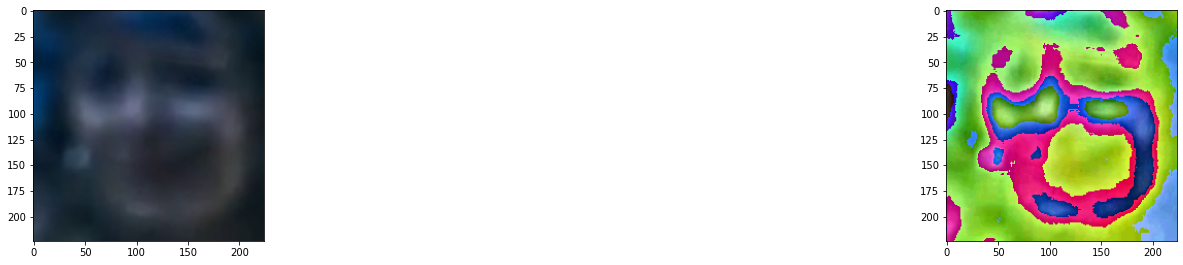

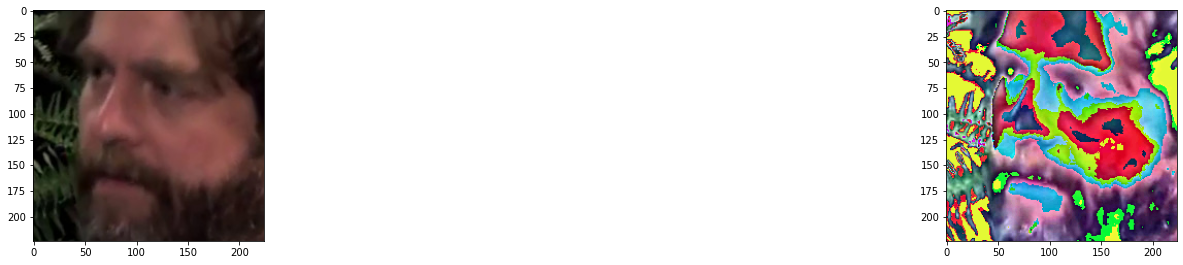

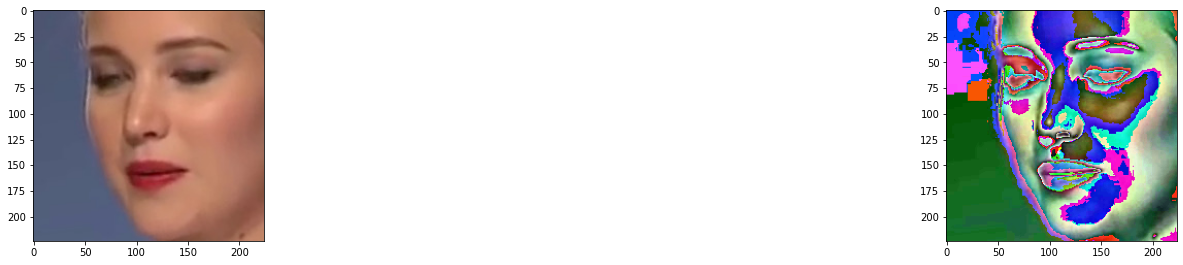

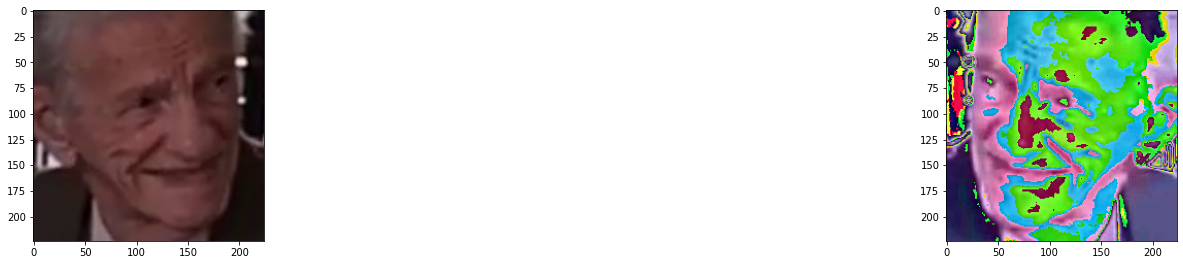

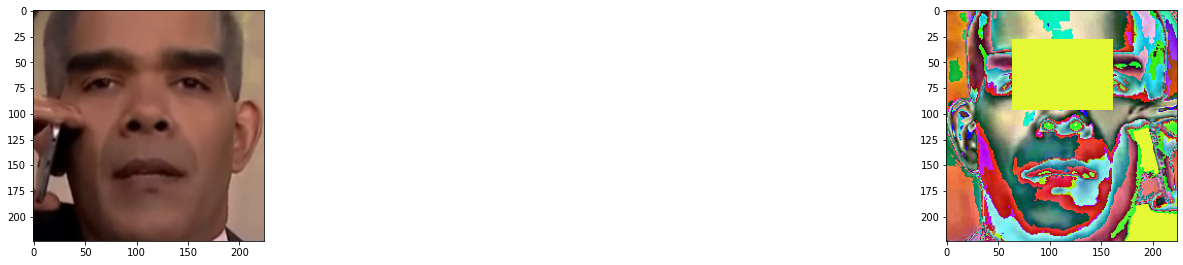

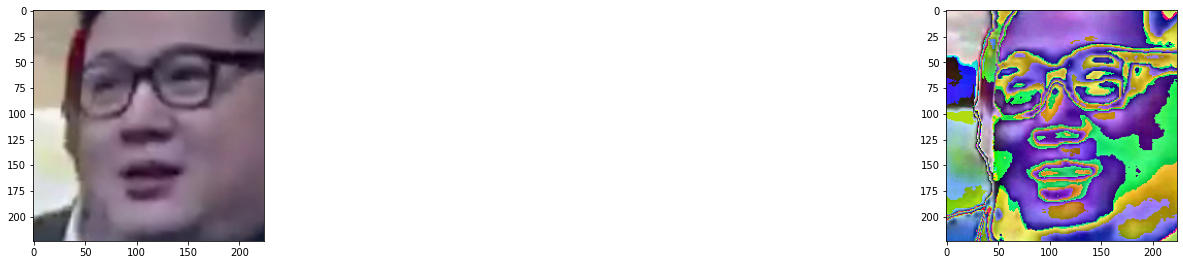

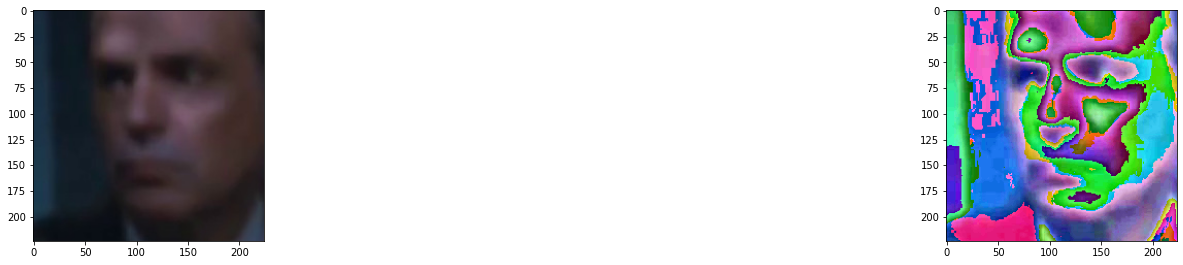

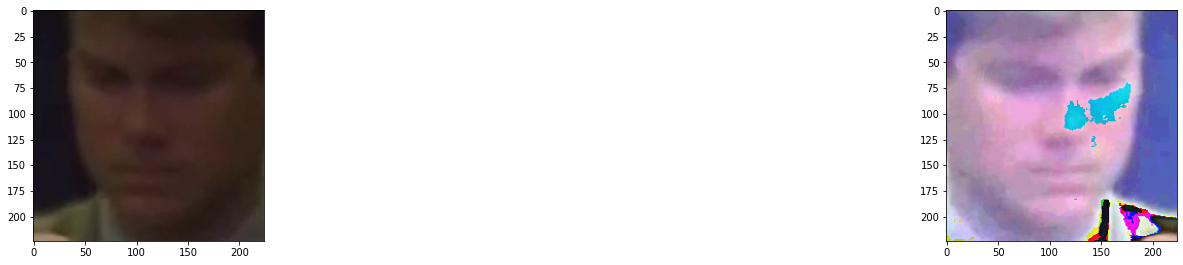

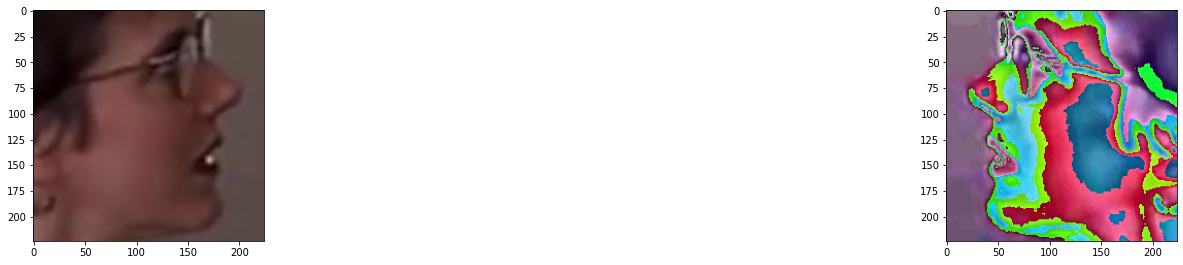

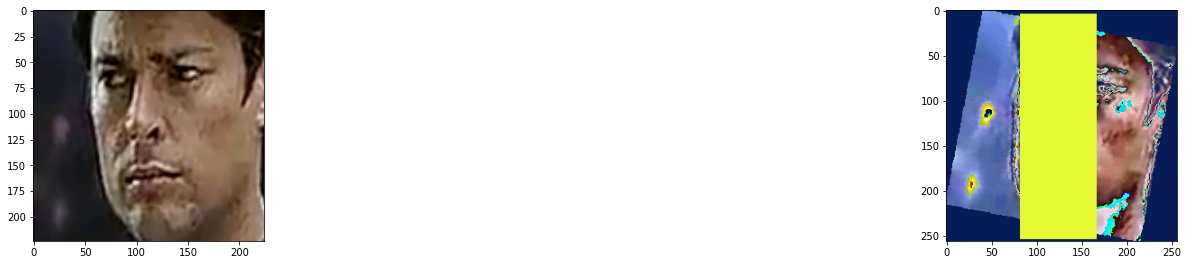

In [193]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from dataloader.transform import AddGaussianNoise
import os.path as osp
import os


for img_path in os.listdir("/mnt/disk1/doan/phucnp/Dataset/df_in_the_wildv4/image/test/0_real/")[:10]:
    img = Image.open(osp.join("/mnt/disk1/doan/phucnp/Dataset/df_in_the_wildv4/image/test/0_real/", img_path))
    plt.figure(figsize=(30, 50))
    plt.subplot(10, 2, 1)
    plt.imshow(img)
    # plt.show()
    img = transform(img)
    # print(img.shape)
    plt.subplot(10, 2, 2)
    plt.imshow(img)
    plt.show()